# **Tutorial 2: Reloading SIDISH model and Visualizing**

In this tutorial, we demonstrate how to reload a previously trained SIDISH model, extract cell embeddings, and visualize the outcomes using UMAP-based methods. These visualizations are crucial for contextualizing high-risk and background cells identified by SIDISH and understanding their relationship to disease features.

## **Step 1: Import libraries**

In [1]:
from SIDISH import SIDISH as sidish
import sys
import scanpy as sc
import pandas as pd
import numpy as np
import  torch
import random
import os
import matplotlib.pyplot as plt

/Users/admin/miniconda3/envs/test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Set Seeds

In [2]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(1)
ite = 0
# Set seeds for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call the seed setting function
set_seed(seed)

## **Step 2: Reload the saved data and SIDISH model**
### **2.1 Reload saved single-cell data**
Before reloading, ensure that you read the exact same `.h5ad` file you used during the training phase. This guarantees that the indices of cells and genes align with the model’s expectations.

   

In [3]:
path = "../data/LUNG/"
adata = sc.read_h5ad("{}adata_SIDISH.h5ad".format(path))

# Read survival+bulk dataset
bulk = pd.read_csv("../data/processed_bulk.csv", index_col=0)

### **2.2 Reload trained SIDISH**
You recreate the SIDISH instance with the same hyperparameters used during the training phase (latent size, layer dimensions, etc.). This ensures that the model’s internal architecture remains consistent with how it was originally trained. By calling `sdh.reload(path)`, you restore the trained VAE and Cox model weights from the specified folder. This step is critical for retaining all learned parameters—such as how the model compresses single-cell data into latent embeddings and how it assigns risk scores based on bulk RNA-seq survival information.


In [4]:
sdh = sidish(adata, bulk, "cuda", seed=ite)
sdh.init_Phase1(225, 20, 32, [512, 128], 512, "Adam", 1.0e-4, 1e-4, 0)
sdh.init_Phase2(500, 128, 1e-4, 0, 0.2, 256)
sdh.reload(path)

SIDISH No spatial graph used. Proceeding with dense VAE.
########################################## Using Dense VAE ##########################################
Reload Complete


## Step 3: Visualize the Cell Type composition or cell cluster
The function `sdh.plot_CellType_UMAP()` projects your data into two dimensions using UMAP. If you set `celltype=False` and provide a resolution parameter, SIDISH will cluster cells automatically (via Leiden clustering):

- **UMAP + Leiden**  
  You get a broad overview of the major cell clusters present in your dataset. Each cluster may correspond to a different cell type or sub-state, depending on your data’s complexity.

- **Customization**  
  You can adjust the UMAP parameters, point size, or clustering resolution to tease out more or fewer clusters, depending on your analytical goals.



OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/admin/Library/CloudStorage/OneDrive-McGillUniversity/PhD/PhD 3/SIDISH/SIDISH/SIDISH.py:585: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(self.adata, resolution=resolution, random_state=self.seed)
/Users/admin/Library/CloudStorage/OneDrive-McGillUniversity/PhD/PhD 3/SIDISH/SIDISH/SIDISH.py:631: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper center", frameon=False, markerscale=1.5, bbox_to_anchor=(0.5, 1.15))


<Figure size 800x600 with 0 Axes>

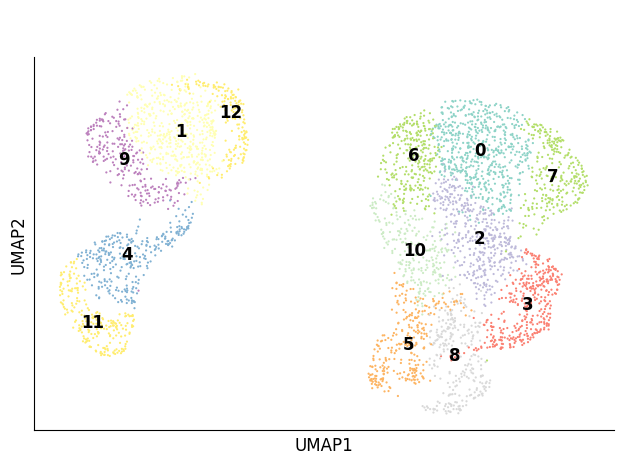

In [5]:
sdh.plot_CellType_UMAP(resolution=0.8,celltype=False)

## Step 4: Visualize the High-Risk cells identified by ***SIDISH***
The function `sdh.plot_HighRisk_UMAP()` overlays the SIDISH-identified High-Risk cells (in red) on the same UMAP. By comparing it to the cluster or cell-type view from Step 3, you can pinpoint exactly which subpopulations (or clusters) harbor the largest fractions of high-risk cells.

- **High-Risk vs. Background**  
  Cells colored in gray are background (non-high-risk), making it straightforward to see how high-risk cells are distributed spatially.

- **Resolution Parameter**  
  As with the cell-type UMAP, you can tweak resolution to either merge or subdivide clusters, potentially revealing smaller niches of high-risk cells that might be biologically interesting.


<Figure size 800x600 with 0 Axes>

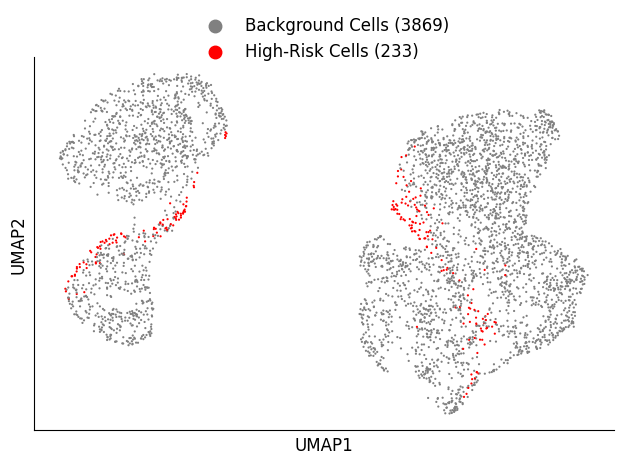

In [6]:
sdh.plot_HighRisk_UMAP(resolution = 0.08, celltype=False)

## Step 5: Find upregulated and down-regulated genes between High-Risk and Background cells identified by ***SIDISH***
Using `upregulated_genes, downregulated_genes = sdh.get_MarkerGenes()`, you can quickly identify which genes are more highly expressed in high-risk cells versus background cells—and vice versa. This is particularly useful for:

1. **Biological Insight**  
   Genes found to be strongly upregulated in the high-risk population may drive disease progression or reflect key vulnerabilities in those cells. Conversely, genes that are downregulated in high-risk cells but active in background cells might suggest protective or housekeeping pathways.

2. **Candidate Biomarkers**  
   These markers can be used to design follow-up experiments or develop targeted therapies focusing on the pathways that differentiate high-risk cells from the rest of the tissue.


In [7]:
upregulated_genes, downregulated_genes = sdh.get_MarkerGenes(logfc_threshold=1)

In [8]:
upregulated_genes

array(['NDRG1', 'SLC2A1', 'ERO1A', 'VEGFA', 'P4HA1', 'WSB1', 'SLC16A3',
       'BNIP3', 'QSOX1', 'CA9', 'TINAGL1', 'NDUFA4L2', 'FBXO32', 'KLF6',
       'LAMB3', 'IGFBP3', 'PNISR', 'BCAM', 'FAM129B', 'PMEPA1', 'LDHA',
       'ITGA3', 'ERRFI1', 'MUC1', 'CEBPB', 'HCFC1R1', 'ANKRD37', 'PLOD2',
       'ADM', 'AGRN', 'ZFP36L1', 'PRSS8', 'WDR60', 'MKNK2', 'PLEC',
       'GPRC5A', 'ANGPTL4', 'CD55', 'ETS2', 'NUPR1', 'PDIA4', 'ST14',
       'SDC4', 'SKIL', 'MPZL2', 'JUND', 'ESYT2', 'CPD', 'ITGB4', 'SEMA3B',
       'SLC5A3', 'TIMP2', 'PTP4A2', 'EGLN3', 'FOXP1', 'SAT1', 'TM4SF1',
       'BCL2L1', 'NMB', 'HIST1H2AC', 'PHLDA2', 'TREM1', 'CHMP1B',
       'GALNT2', 'CAMK1D', 'CLIP1', 'LIMCH1', 'SLC25A37', 'ZFP36',
       'SYNGR2', 'EMP1', 'TMC6', 'MED15', 'MRPS6', 'WEE1', 'RND3',
       'SRD5A3', 'WFDC2', 'RNF149', 'BRD2', 'IGBP1', 'UGCG', 'C19orf33',
       'XIAP', 'ITGA2', 'C1orf198', 'BIRC3', 'STK4', 'MIDN', 'SNHG19',
       'PIM1', 'PHLDA1', 'MB', 'SMAD2', 'TNFAIP2', 'PJA2', 'CD81',
       'DDIT3

In [9]:
downregulated_genes

array(['SAMD9', 'TPX2', 'CCNB2', 'IFIT3', 'IDO1', 'RARRES1', 'CENPF',
       'S100A7', 'GBP5', 'CDK1', 'UBE2T', 'PTTG1', 'CXCL10', 'BIRC5',
       'CDC20', 'NUSAP1', 'TOP2A', 'GBP1'], dtype=object)

## Step 6: Visualize the survival curve of patients witha high expression of upregulated genes found in the SIDISH identified cells
Finally, `sdh.plot_KM()` enables you to see how patient survival outcomes correlate with the expression of the identified upregulated genes. This links the single-cell insights back to your bulk patient cohorts:

- **High vs. Low Expression Groups**  
  SIDISH can split patients based on whether they have high expression or low expression of your genes of interest.

- **Clinical Relevance**  
  A significant difference in Kaplan-Meier survival curves suggests that these markers are not just biologically distinct, but also clinically important for patient prognosis.


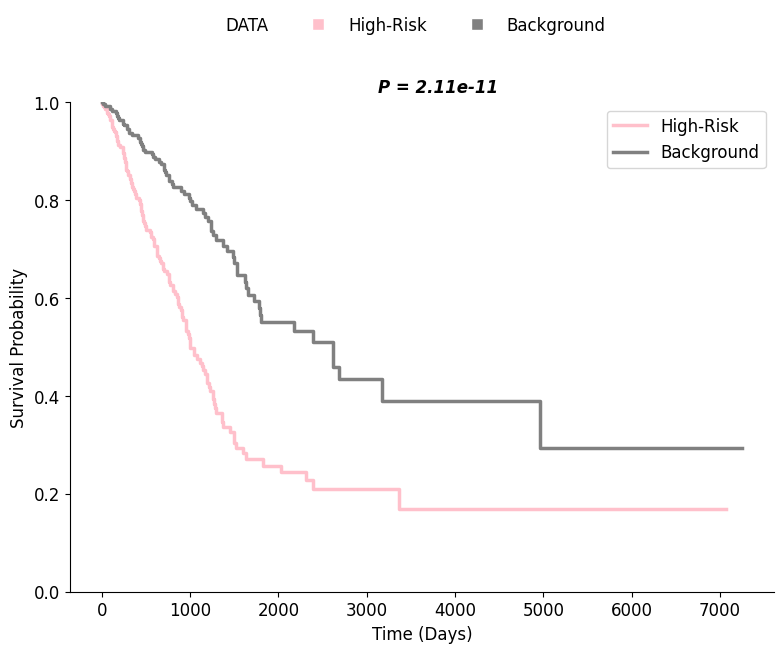

In [10]:
sdh.plot_KM(penalizer=10)